In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from PIL import Image
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
# resize gray black_background
# thresh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
Constants
"""
path = '/content/drive/MyDrive/mosaic/emoji/aug/'
test_ratio = 0.1
validation_ratio = 0.1
img_dim = 28

In [ ]:
"""
Variables
"""
images = []
class_number = []

dir_list = os.listdir(path)
print(dir_list)

number_of_classes = len(dir_list)

['1', '2', '3', '5', '6', '7', '4']


In [ ]:
"""
Import images and resize them.
"""
# for x, folder in enumerate(dir_list):
#     image_list = os.listdir(path + "/" + str(folder))
#     for _, img in enumerate(image_list):
#         current_img = cv2.imread(path + "/" + str(folder) + "/" + img)
#         current_img = cv2.resize(current_img, (img_dim, img_dim))
#         images.append(current_img)
#         class_number.append(x)
#     print(folder)
# print(len(images))

# images = np.array(images)
# class_number = np.array(class_number)

# print(images.shape)
# print(class_number.shape)

for x, folder in enumerate(dir_list):
    image_list = os.listdir(path + "/" + str(folder))
    for _, img in enumerate(image_list):
        current_img = cv2.imread(path + "/" + str(folder) + "/" + img)
        try:
            current_img = cv2.resize(current_img, (img_dim, img_dim))  #resize
        except:
            break
        images.append(current_img)
        class_number.append(x)
    print(folder)
print(len(images))

images = np.array(images)
class_number = np.array(class_number)

print(images.shape)
print(class_number.shape)

1
2
3
5
6
7
4
2428
(2428, 28, 28, 3)
(2428,)


In [ ]:
"""
Split Data for training, testing, and validation.
"""
X_train, X_test, y_train, y_test = train_test_split(images, class_number, test_size = test_ratio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validation_ratio)
print(X_train.shape)
print(X_test.shape)

number_of_samples = []
for idx in range(number_of_classes):
    number_of_samples.append(len(np.where(y_train == idx)[0]))

print(number_of_samples)

# plt.figure(figsize = (10, 5))
# plt.bar(range(number_of_classes), number_of_samples)
# plt.title("Number of images for each Emoji")
# plt.xlabel("Emoji ID")
# plt.ylabel("Number of images")
# plt.show()


(1966, 28, 28, 3)
(243, 28, 28, 3)
[278, 269, 295, 298, 281, 274, 271]


In [ ]:
def pre_process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    #gray
    img=cv2.bitwise_not(img)    #black_background
    # img = cv2.equalizeHist(img)
    # ret, thresh2 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
    return img/255

""" img = pre_process(X_train[20])
img = cv2.resize(img, (300, 300))
cv2.imshow("Preprocessed Image", img)
cv2.waitKey(0) """

X_train = np.array(list(map(pre_process, X_train)))
X_test = np.array(list(map(pre_process, X_test)))
X_validation = np.array(list(map(pre_process, X_validation)))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)

data_generator = ImageDataGenerator(width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    rotation_range = 10)

data_generator.fit(X_train)

y_train = to_categorical(y_train, number_of_classes)
y_test = to_categorical(y_test, number_of_classes)
y_validation = to_categorical(y_validation, number_of_classes)

In [ ]:
def create_model():
    number_of_filters = 60  #80
    size_of_filter1 = (5, 5)
    size_of_filter2 = (3, 3)
    size_of_pool = (2, 2)
    number_of_nodes = 500

    model = Sequential()
    model.add(Conv2D(number_of_filters, size_of_filter1, input_shape = (img_dim, img_dim, 1), activation = "relu"))
    model.add(Conv2D(number_of_filters, size_of_filter1, activation = "relu"))
    model.add(MaxPooling2D(pool_size = size_of_pool))
    model.add(Conv2D(number_of_filters // 2, size_of_filter2, activation = "relu"))
    model.add(Conv2D(number_of_filters // 2, size_of_filter2, activation = "relu"))
    model.add(MaxPooling2D(pool_size = size_of_pool))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(number_of_nodes, activation = "relu"))
    model.add(Dropout(0.4))
    model.add(Dense(number_of_classes, activation = "softmax"))
    model.compile(Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])
    return model

model = create_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 60)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 30)          16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 30)         0         
 2D)                                                  

In [ ]:
# model = CNNModel().to(device)
# model

Epoch 1/50
19/19 [==============================] - 1s 35ms/step - loss: 1.9398 - accuracy: 0.1382 - val_loss: 1.9313 - val_accuracy: 0.1735
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 1.8987 - accuracy: 0.2829 - val_loss: 1.7845 - val_accuracy: 0.3288
Epoch 3/50
19/19 [==============================] - 0s 17ms/step - loss: 1.6011 - accuracy: 0.3618 - val_loss: 1.2009 - val_accuracy: 0.5708
Epoch 4/50
19/19 [==============================] - 0s 17ms/step - loss: 1.4091 - accuracy: 0.4836 - val_loss: 1.1961 - val_accuracy: 0.5251
Epoch 5/50
19/19 [==============================] - 0s 19ms/step - loss: 1.4090 - accuracy: 0.4507 - val_loss: 0.9941 - val_accuracy: 0.6575
Epoch 6/50
19/19 [==============================] - 0s 19ms/step - loss: 1.1178 - accuracy: 0.5592 - val_loss: 0.8264 - val_accuracy: 0.7580
Epoch 7/50
19/19 [==============================] - 1s 26ms/step - loss: 1.0336 - accuracy: 0.6192 - val_loss: 0.7763 - val_accuracy: 0.7717
Epoch 8/50
19

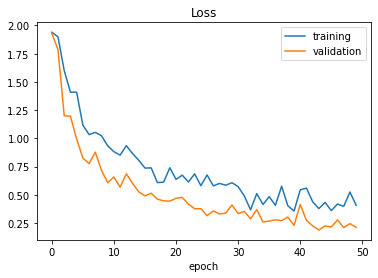

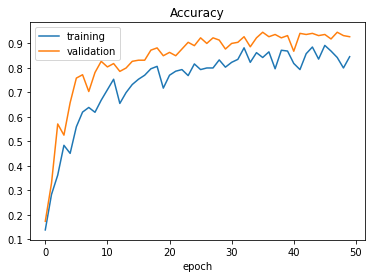

Test score:  0.1507570445537567
Test accuracy:  0.9465020298957825


In [ ]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/modified_weights-{epoch:03d}.h5',
                                 monitor='val_acc',
                                 verbose=0,
                                 save_best_only=False,
                                 mode='auto')

history = model.fit(data_generator.flow(X_train, y_train,
                                        batch_size = 16),
                                        steps_per_epoch = 19,
                                        epochs = 50,
                                        validation_data = (X_validation, y_validation),
                                        shuffle = 1)

plt.figure(1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training", "validation"])
plt.title("Loss")
plt.xlabel("epoch")

plt.figure(2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["training", "validation"])
plt.title("Accuracy")
plt.xlabel("epoch")
plt.show()

score = model.evaluate(X_test, y_test, verbose = 0)
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

# pickle_out = open("model_trained.p", "wb")
# pickle.dump(model, pickle_out)
# pickle_out.close()

In [ ]:
model.save('/content/drive/My Drive/only_emoji_1.h5')